In [35]:
# Library Imports
import pandas as pd
import numpy as np
import re
import joblib  # For model serialization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
 

 
 

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mngom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Printing the stopwords in English
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

## Dataset Loading and Combination
 

In [9]:
# Load the datasets
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

# Add labels
fake_df['label'] = 1
real_df['label'] = 0

# Combine the datasets
df = pd.concat([real_df, fake_df], ignore_index=True)

# Save the combined dataset (initial version without stemmed content)
df.to_csv('new_dataset.csv', index=False)

print(f"Total samples: {df.shape[0]}")
print("Class distribution:")
print(df['label'].value_counts(normalize=True).round(3))
print("\nSample records:")
print(df[['title', 'text', 'subject', 'label']].head())

Total samples: 44898
Class distribution:
label
1    0.523
0    0.477
Name: proportion, dtype: float64

Sample records:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  label  
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews      0  
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews      0  
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews      0  
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews      0  
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews      0  


## Data Pre-processing

In [7]:
# loading the dataset into pandas dataframe
news_dataset = pd.read_csv('new_dataset.csv')

In [8]:
news_dataset.shape

(44898, 5)

In [ ]:
# print the first 5 rows of the dataframe
news_dataset.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [10]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [11]:
# merging the news title, text and, subject in  to a new feature 'content'
news_dataset['content'] = news_dataset['title']+' '+news_dataset['text']+' '+news_dataset['subject']

print(news_dataset['content'])

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
44893    McPain: John McCain Furious That Iran Treated ...
44894    JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895    Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896    How to Blow $700 Million: Al Jazeera America F...
44897    10 U.S. Navy Sailors Held by Iranian Military ...
Name: content, Length: 44898, dtype: object


In [12]:
#Seprating the data & label
X = news_dataset.drop('label', axis=1)
y = news_dataset['label']

print(X)
print(y)


                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv... 

# stemming 

 reducing a word to its Roots( removes prefix and surfix in a word)

In [4]:
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [13]:
news_dataset['content'] = news_dataset['content'].apply(stemming)

news_dataset.to_csv('stemmed_dataset.csv', index=False)

In [14]:
print(news_dataset['content'])

0        u budget fight loom republican flip fiscal scr...
1        u militari accept transgend recruit monday pen...
2        senior u republican senat let mr mueller job w...
3        fbi russia probe help australian diplomat tip ...
4        trump want postal servic charg much amazon shi...
                               ...                        
44893    mcpain john mccain furiou iran treat us sailor...
44894    justic yahoo settl e mail privaci class action...
44895    sunnistan us alli safe zone plan take territor...
44896    blow million al jazeera america final call qui...
44897    u navi sailor held iranian militari sign neoco...
Name: content, Length: 44898, dtype: object


In [ ]:
#separating the data and label
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [15]:
print(X)

                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv... 

In [18]:
print(y)
y.shape

0        0
1        0
2        0
3        0
4        0
        ..
44893    1
44894    1
44895    1
44896    1
44897    1
Name: label, Length: 44898, dtype: int64


(44898,)

In [45]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the raw text content (strings), not on an already-transformed sparse matrix.
# news_dataset['content'] contains the preprocessed text strings.
vectorizer.fit(news_dataset['content'])

# Transform the raw text into the feature matrix
X = vectorizer.transform(news_dataset['content'])

# Save the vectorizer to a .pkl file
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print('Vectorizer saved!')

Vectorizer saved!


In [46]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6947929 stored elements and shape (44898, 89870)>
  Coords	Values
  (0, 619)	0.024818939426569573
  (0, 710)	0.03629432564342534
  (0, 821)	0.04379811866295902
  (0, 1281)	0.027119363685103946
  (0, 1431)	0.11368089440375002
  (0, 2286)	0.025165187769098585
  (0, 2301)	0.04555449357117973
  (0, 2694)	0.05176885695914937
  (0, 3594)	0.03363655543487999
  (0, 3598)	0.029401983637325345
  (0, 4070)	0.033163687860670185
  (0, 4418)	0.06635135781522437
  (0, 5357)	0.018312500804936963
  (0, 5693)	0.05417476778146204
  (0, 6317)	0.03328035244383042
  (0, 6761)	0.029510602136599846
  (0, 7596)	0.027055276108627044
  (0, 7609)	0.03163593146428857
  (0, 7670)	0.07337065531728464
  (0, 7697)	0.05749814382442261
  (0, 8864)	0.03643670978669809
  (0, 8898)	0.028340608189331377
  (0, 8957)	0.048148108682138764
  (0, 9262)	0.05610191860189442
  (0, 9936)	0.03187419413618037
  :	:
  (44897, 81350)	0.03305821788817139
  (44897, 81601)	0.019

## Splitting the dataset to training & test data

In [23]:
# Recreate a consistent feature matrix from the content column so X and labels have matching sample counts.
# Fit/transform the vectorizer on the full content to ensure the feature matrix aligns with news_dataset and y.
X_features = vectorizer.fit_transform(news_dataset['content'])

# Split using the newly created feature matrix and the label column from the dataframe (or use 'y' which is equivalent)
X_train, X_test, Y_train, Y_test = train_test_split(
	X_features,
	news_dataset['label'],
	test_size=0.2,
	stratify=news_dataset['label'],
	random_state=2
)

## Training the Model: Logistic Regression

In [24]:
model = LogisticRegression()

model.fit(X_train, Y_train)

LogisticRegression()

## Evaluation



## accuracy score

In [25]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [26]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9940698257141266


In [27]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [28]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9916481069042317


## Making a Predictive System

In [33]:
X_new = X_test[8]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [34]:
# Use positional indexing to avoid KeyError when the Series index is not sequential
print(Y_test.iloc[8])

0


## Learning Curves

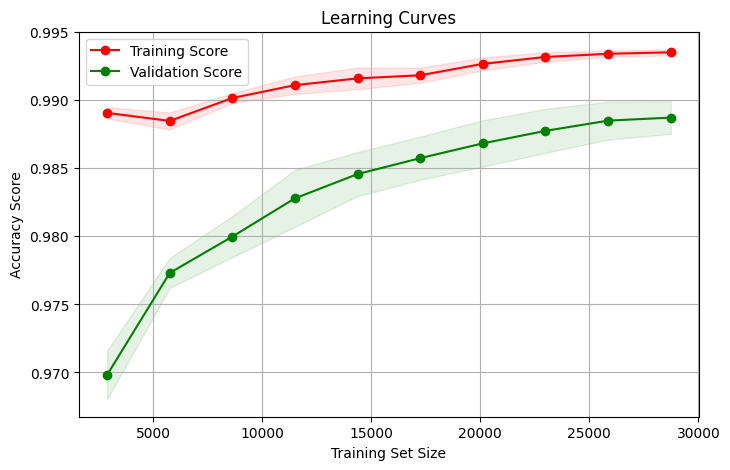

In [40]:
# Compute learning curves (train_sizes, train_scores, val_scores)
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, Y_train, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Plot
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()   

## Precision-Recall Curve

Average Precision Score: 0.9995


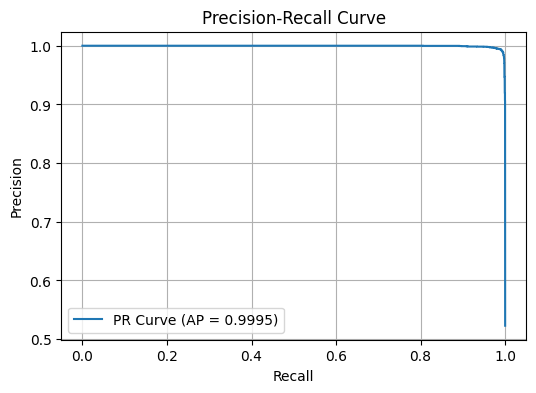

In [37]:
# Get precision-recall data
# compute predicted probabilities for the positive class on the test set
y_test_proba = model.predict_proba(X_test)[:, 1]

precision, recall, pr_thresholds = precision_recall_curve(Y_test, y_test_proba)
avg_precision = average_precision_score(Y_test, y_test_proba)

print(f"Average Precision Score: {avg_precision:.4f}")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix

Confusion Matrix (Raw):
[[4247   37]
 [  38 4658]]


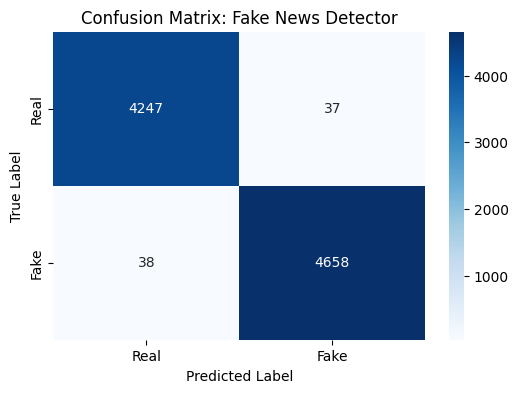

In [38]:

# Get predictions
X_test_prediction = model.predict(X_test)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, X_test_prediction)
print("Confusion Matrix (Raw):")
print(cm)

# Labels for clarity (0: Real, 1: Fake)
labels = ['Real', 'Fake']

# Visualize with heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Fake News Detector')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()  # Displays the plot; add plt.savefig('confusion_matrix.png') to save

## ROC-AUC Score and ROC Curve Plot

ROC-AUC Score: 0.9994
Interpretation: >0.9 = Excellent, 0.8-0.9 = Good, <0.8 = Needs work


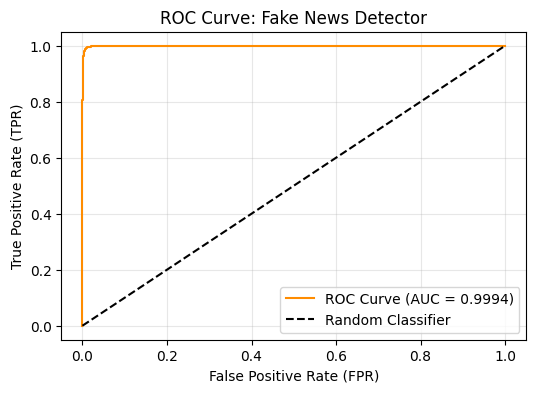

In [ ]:
# Get probabilities for ROC (positive class: Fake=1)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Fake)

# Compute AUC score
auc_score = roc_auc_score(Y_test, y_test_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")
print("Interpretation: >0.9 = Excellent, 0.8-0.9 = Good, <0.8 = Needs work")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(Y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Fake News Detector')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()  # Or plt.savefig('roc_curve.png') to save

## Class Distribution and Prediction Histogram

Test Set Class Distribution: {'Real': np.int64(4284), 'Fake': np.int64(4696)}


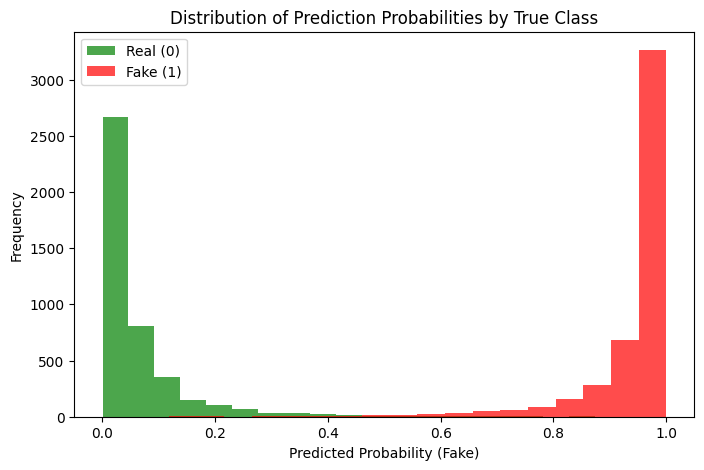

In [41]:
# Class distribution in test set
unique, counts = np.unique(Y_test, return_counts=True)
class_dist = dict(zip(['Real' if u == 0 else 'Fake' for u in unique], counts))
print("Test Set Class Distribution:", class_dist)

# Histogram of prediction probabilities
plt.figure(figsize=(8, 5))
plt.hist(y_test_proba[Y_test == 0], bins=20, alpha=0.7, label='Real (0)', color='green')
plt.hist(y_test_proba[Y_test == 1], bins=20, alpha=0.7, label='Fake (1)', color='red')
plt.xlabel('Predicted Probability (Fake)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities by True Class')
plt.legend()
plt.show()  # Or plt.savefig('pred_distributions.png')

## Save the Trained Model

In [42]:
import joblib

# Save the trained model to a .pkl file
model_filename = 'fake_news_detector.pkl'
joblib.dump(model, model_filename)
print(f'Trained model saved successfully as {model_filename}! Ready for deployment.')

# Optional: Quick verification by loading and predicting on one sample
loaded_model = joblib.load(model_filename)
quick_pred = loaded_model.predict(X_test[0:1])  # First test sample
print(f"Verification: Loaded model predicts {quick_pred[0]} on first test sample (matches original? {quick_pred[0] == model.predict(X_test[0:1])[0]})")

Trained model saved successfully as fake_news_detector.pkl! Ready for deployment.
Verification: Loaded model predicts 1 on first test sample (matches original? True)
